### Note: this model isn't supposed to be good, it's using only one word to predict the label and most of the input words are the same. This is just practicing with the framework

In [1]:
%load_ext autoreload
%autoreload 2

In [110]:
from jupyter_helpers import *
from helpers import *

set_seed(99, True)

In [60]:
bs = 64

lm_dls = get_lm_dls(bs)
text_dls = get_text_classifier_dls(bs, lm_dls)

,text,text_
0,xxbos,andraponni
1,xxbos,xxup
2,xxup,adt45
3,karnatakaponni,xxbos
4,xxbos,xxup
5,xxup,adt45
6,xxbos,xxup
7,adt45,xxbos
8,adt45,xxbos


In [ ]:
lm_dls.show_batch()

In [ ]:
text_dls.show_batch()

In [ ]:
lm_vocab = lm_dls.vocab
text_classifier_vocab = list(dls.vocab[0]) + list(dls.vocab[1])

len(lm_vocab), len(dls.vocab), len(dls.vocab[0]), len(dls.vocab[1]), len(text_classifier_vocab)

# Get HF Text Model

In [195]:
from transformers import BertTokenizer, BertModel, AutoModelForPreTraining

In [ ]:
bert_arch = "bert-base-uncased"

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_arch, seq_length=10)

In [196]:
text = ["Replace me by any text you'd like.", "Just another test.", "this one is longer than 10 words blah blah blah blah blah blah blah"]
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

output.prediction_logits.shape, output.seq_relationship_logits.shape

(torch.Size([2, 12, 30522]), torch.Size([2, 2]))

In [197]:
encoded_input

{'input_ids': tensor([[ 101, 5672, 2033, 2011, 2151, 3793, 2017, 1005, 1040, 2066, 1012,  102],
        [ 101, 5672, 2033, 2011, 2151, 3793, 2017, 1005, 1040, 2066, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

# Create a datablock

In [239]:
indices = list(range_of(df))
np.random.shuffle(indices)

train_sz = int(0.8 * len(indices))

splits = [indices[:train_sz], indices[train_sz:]]
tfms = [
    lambda x: x.variety.lower(), 
    partial(tokenizer, return_tensors='pt', 
            add_special_tokens=True, padding=True, 
            pad_to_multiple_of=7),
]
tfms_label = [Categorize()]
dsets = Datasets(df, [tfms, tfms_label], splits=splits)

In [240]:
dsets[0]

({'input_ids': tensor([[  101,  4748,  2102, 19961,   102,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0]])},
 TensorCategory(0))

In [241]:
def create_batch(x):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    labels = []
    for row, y in x:
        input_ids.append(row['input_ids'])
        token_type_ids.append(row['token_type_ids'])
        attention_mask.append(row['attention_mask'])
        labels.append(y)
    return (
        {
            'input_ids': torch.stack(input_ids).squeeze(1),
            'token_type_ids': torch.stack(token_type_ids).squeeze(1),
            'attention_mask': torch.stack(attention_mask).squeeze(1),
        },
        tensor(labels)
    )

dls = dsets.dataloaders(bs=bs, seq_len=1, 
                        shuffle=True, device=device,
                        create_batch=create_batch)
x, y = dls.one_batch()
x['input_ids'].shape, x['token_type_ids'].shape, x['attention_mask'].shape, y.shape

(torch.Size([64, 7]),
 torch.Size([64, 7]),
 torch.Size([64, 7]),
 torch.Size([64]))

# Train classifier

In [246]:
class HFTextClassifier(Module):
    def __init__(self, with_relu: bool = False):
        self.model = AutoModelForPreTraining.from_pretrained(bert_arch).bert
        self.linear = nn.Linear(self.model.config.hidden_size, len(text_classifier_vocab))
        
        if with_relu:
            self.linear = nn.Sequential(nn.ReLU(), self.linear)
    
    def forward(self, x):
        x = self.model(**x)
        x = self.linear(x.pooler_output)
        return x

def hf_splitter(m):
    return (params(m.model), params(m.linear))

SuggestedLRs(steep=0.0004786300996784121, valley=4.365158383734524e-05)

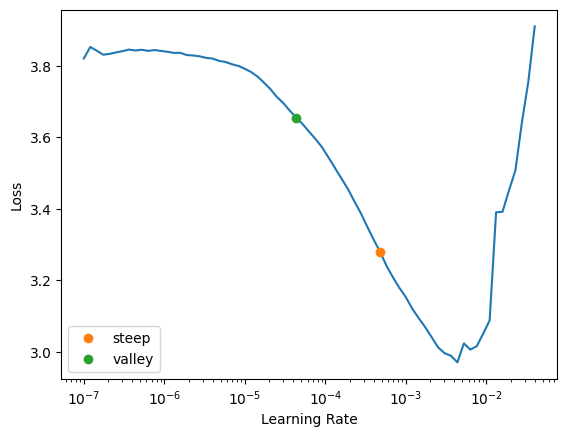

In [247]:
with safely_train_with_gpu():
    learn = Learner(dls, HFTextClassifier(with_relu=False), splitter=hf_splitter,
                    metrics=[accuracy], cbs=[ShowGraphCallback()])
    print(learn.lr_find(suggest_funcs=(steep, valley)))

In [249]:
with safely_train_with_gpu():
    train_learner(dls, HFTextClassifier(with_relu=False), hf_splitter)

epoch,train_loss,valid_loss,accuracy,time
0,2.171323,2.062184,0.244957,00:36


epoch,train_loss,valid_loss,accuracy,time
0,1.975538,1.944403,0.303074,00:39
1,2.155164,2.157429,0.170509,00:39
2,2.160076,2.154014,0.163785,00:39


In [ ]:
with safely_train_with_gpu():
    train_learner(dls, HFTextClassifier(with_relu=True), hf_splitter)